In [11]:
# Enhanced Anomaly Detection with Variational Autoencoder (VAE)

## Required Libraries
import numpy as np
import torch
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan
Epoch 11, Loss: nan
Epoch 12, Loss: nan
Epoch 13, Loss: nan
Epoch 14, Loss: nan
Epoch 15, Loss: nan
Epoch 16, Loss: nan
Epoch 17, Loss: nan
Epoch 18, Loss: nan
Epoch 19, Loss: nan
Epoch 20, Loss: nan
Epoch 21, Loss: nan
Epoch 22, Loss: nan
Epoch 23, Loss: nan
Epoch 24, Loss: nan
Epoch 25, Loss: nan
Epoch 26, Loss: nan
Epoch 27, Loss: nan
Epoch 28, Loss: nan
Epoch 29, Loss: nan
Epoch 30, Loss: nan
Epoch 31, Loss: nan
Epoch 32, Loss: nan
Epoch 33, Loss: nan
Epoch 34, Loss: nan
Epoch 35, Loss: nan
Epoch 36, Loss: nan
Epoch 37, Loss: nan
Epoch 38, Loss: nan
Epoch 39, Loss: nan
Epoch 40, Loss: nan
Epoch 41, Loss: nan
Epoch 42, Loss: nan
Epoch 43, Loss: nan
Epoch 44, Loss: nan
Epoch 45, Loss: nan
Epoch 46, Loss: nan
Epoch 47, Loss: nan
Epoch 48, Loss: nan
Epoch 49, Loss: nan
Epoch 50, Loss: nan


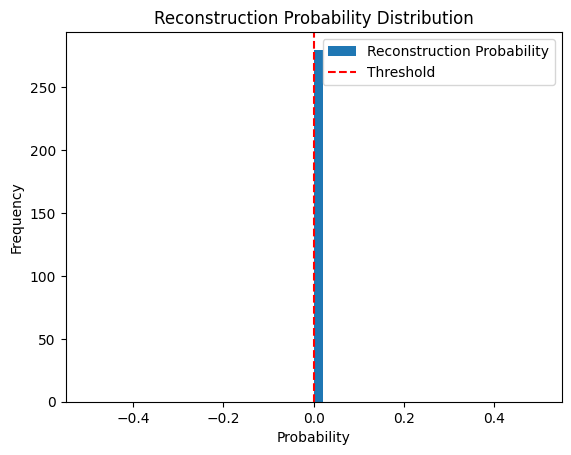

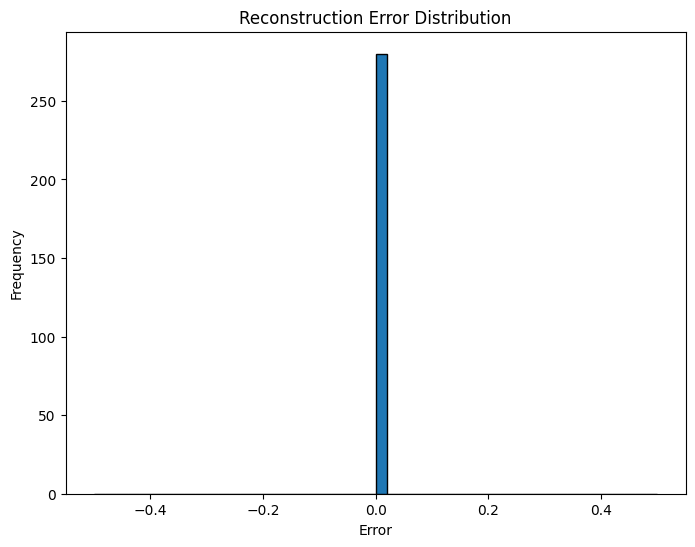

In [21]:
## Load and Preprocess Dataset
# Replace `yahoo_sub_5.csv` with your dataset file.
data = pd.read_csv("yahoo_sub_5.csv", delimiter=",")

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Normalize the 'value_0' column for scaling and analysis
scaler = StandardScaler()
data['value_scaled'] = scaler.fit_transform(data[['value_0']])

# Split the dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_features = torch.tensor(train_data.drop(columns=['anomaly']).values, dtype=torch.float32)
test_features = torch.tensor(test_data.drop(columns=['anomaly']).values, dtype=torch.float32)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(train_features), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_features), batch_size=batch_size, shuffle=False)

## Define the VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        enc_out = self.encoder(x)
        mean, log_var = torch.chunk(enc_out, 2, dim=-1)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

## Train the VAE
def train_vae(model, dataloader, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, in dataloader:
            optimizer.zero_grad()
            recon, mean, log_var = model(x)
            kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            recon_loss = criterion(recon, x)
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

## Initialize and Train the Model
input_dim = train_features.shape[1]
hidden_dim = 128
latent_dim = 16

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_vae(vae, train_loader, optimizer, criterion, epochs=50)

## Evaluate and Analyze Reconstruction Probabilities
vae.eval()
with torch.no_grad():
    recon_probs = []
    for x, in test_loader:
        recon, _, _ = vae(x)
        prob = torch.mean((recon - x)**2, dim=-1)
        recon_probs.append(prob.numpy())
    recon_probs = np.concatenate(recon_probs)

# Handle NaN values
recon_probs = np.nan_to_num(recon_probs, nan=0.0, posinf=0.0, neginf=0.0)

# Dynamic Thresholding (e.g., 95th percentile)
threshold = np.percentile(recon_probs, 99)

## Visualization: Reconstruction Probability Distribution
plt.hist(recon_probs, bins=50, label='Reconstruction Probability')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error, bins=50, edgecolor='k')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


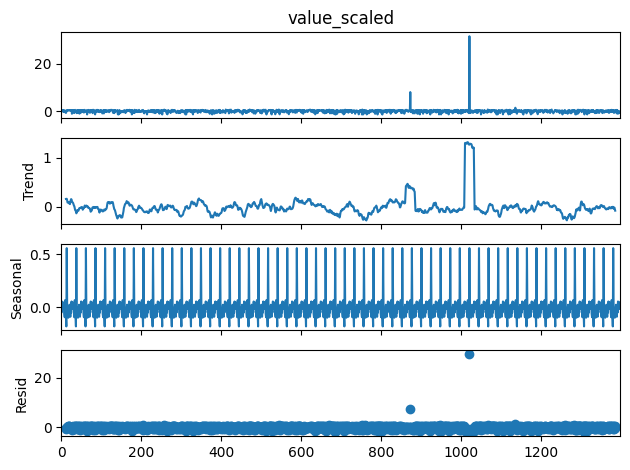

In [22]:
## Seasonal Decomposition
decomposition = seasonal_decompose(data['value_scaled'], model='additive', period=24)  # Adjust 'period' to your data frequency
decomposition.plot()
plt.show()


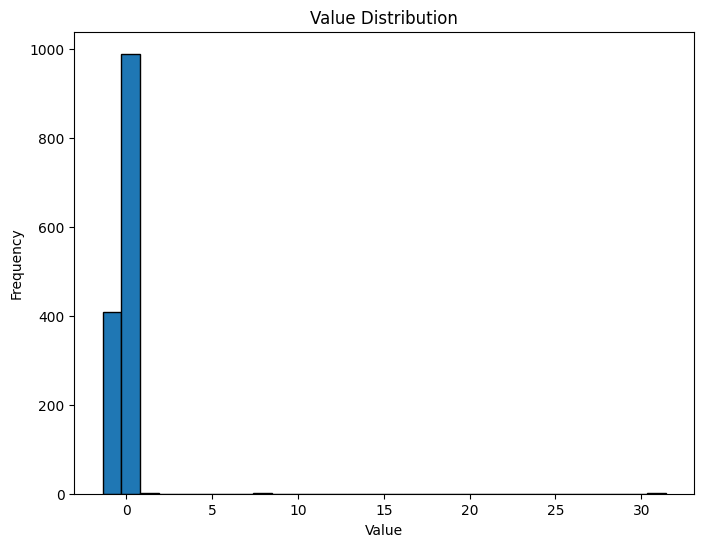

In [23]:
## Value Distribution
plt.figure(figsize=(8, 6))
plt.hist(data['value_scaled'], bins=30, edgecolor='k')
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Number of anomalies detected: 0
Anomalous values:
Series([], Name: value_scaled, dtype: float64)


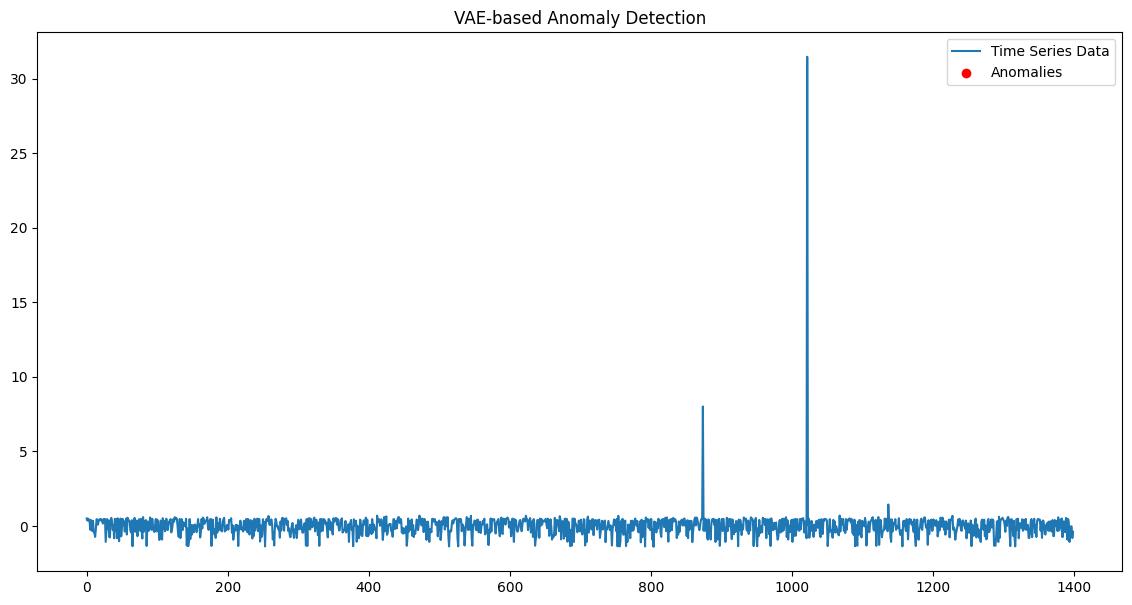

In [24]:
## Anomaly Detection and Visualization
# Define a threshold for anomaly detection
reconstruction_error = recon_probs  # Assuming recon_probs contains the errors
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
test_indices = data.index[-len(reconstruction_error):]  # Get indices for the test set
data['is_anomaly'] = 0  # Initialize all as non-anomalous
data.loc[test_indices, 'is_anomaly'] = [
    1 if error > threshold else 0 for error in reconstruction_error
]

# Print number of anomalies and their values
num_anomalies = data['is_anomaly'].sum()
anomalies = data[data['is_anomaly'] == 1]['value_scaled']
print(f"Number of anomalies detected: {num_anomalies}")
print("Anomalous values:")
print(anomalies)

# Visualize anomalies
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['value_scaled'], label='Time Series Data')
plt.scatter(
    data[data['is_anomaly'] == 1].index, 
    data[data['is_anomaly'] == 1]['value_scaled'], 
    color='red', label='Anomalies'
)
plt.title('VAE-based Anomaly Detection')
plt.legend()
plt.show()



